# Import packages & functions

In [1]:
import os
import sys
import json
import argparse
import numpy as np
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds
from PIL import Image
import pandas as pd
import nibabel as nib

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
seed = 0
import utils

def find_paired_indices(x):
    unique_elements, counts = torch.unique(x, return_counts=True)
    repeated_elements = unique_elements[counts > 1]
    paired_indices = []
    for element in repeated_elements:
        indices = (x == element).nonzero(as_tuple=True)[0]
        for i in range(len(indices) - 1):
            for j in range(i + 1, len(indices)):
                paired_indices.append([indices[i].item(), indices[j].item()])
    return paired_indices

def zscore(data):
    # assuming that first dim is num_samples and second dim is num_voxels
    train_mean = np.mean(data,axis=0)
    train_std = np.std(data,axis=0)
    zscored_data = (data - train_mean) / (train_std + 1e-6)
    return zscored_data

# Princeton data prep

## Load images

torch.Size([850, 3, 224, 224])
design (850, 4608)
image_idx torch.Size([1000])


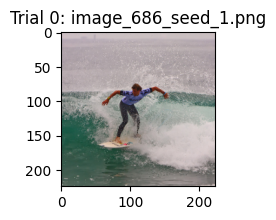

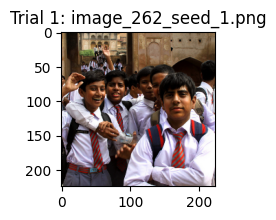

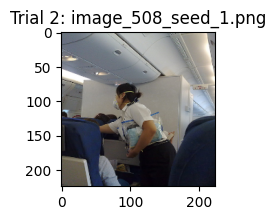

In [261]:
images, image_names = utils.load_images_to_numpy("rtmindeye_stimuli")
images = torch.Tensor(images / 255).permute(0,3,1,2) 
print(images.shape)

train_image_, test_image_, ii = [], [], 0

num_runs = 16
for r in range(num_runs):
    file_out = pd.read_csv(f"csv/design_participant1run{r}.csv")
    headers = file_out.columns.values
    values = file_out.values
    values[:,0] = 0 # remove 0th column numbering
    inds = np.argmax(values,axis=1)
    inds = inds[inds!=0]
    if r==0:
        design = file_out.to_numpy()
        images_sorted = headers[inds]
    else:
        design = np.vstack((design, file_out.to_numpy()))
        images_sorted = np.hstack((images_sorted, headers[inds]))
    for h in headers[inds]:
        if "_seed_" not in h:
            test_image_ = np.append(test_image_, ii)
        else:
            train_image_ = np.append(train_image_, ii)
        ii += 1
                
design = design[:,1:].T
print("design", design.shape)

image_idx = torch.Tensor([image_names.index(im) for im in images_sorted]).long()
print("image_idx", image_idx.shape)

# sort the images according to the experimental presentation
images = images[image_idx]

assert len(test_image_) == 100

pairs = find_paired_indices(image_idx)
pairs = np.array(sorted(pairs, key=lambda x: x[0]))

plt.figure(figsize=(2,2))
plt.imshow(images[0].permute(1,2,0).numpy())
plt.title(f"Trial 0: {image_names[image_idx[0]]}")
plt.show()
plt.figure(figsize=(2,2))
plt.imshow(images[1].permute(1,2,0).numpy())
plt.title(f"Trial 1: {image_names[image_idx[1]]}")
plt.show()
plt.figure(figsize=(2,2))
plt.imshow(images[2].permute(1,2,0).numpy())
plt.title(f"Trial 2: {image_names[image_idx[2]]}")
plt.show()

## Load GLMSingle voxel data

In [247]:
glmsingle = np.load("glmsingle/TYPED_FITHRF_GLMDENOISE_RR.npz",allow_pickle=True) #_GLMDENOISE_RR
vox = glmsingle['betasmd'][:,0,0].T
print("vox", vox.shape)

vox (1000, 165240)


### Load nsdgeneral ROI

In [248]:
brain_mask = nib.load('sub-001_ses-01_brain.nii.gz').get_fdata().flatten()
print(f"total voxels (whole brain) = {int(brain_mask.sum())}")
roi = nib.load('sub-001_nsdgeneral.nii.gz').get_fdata()

roi = roi.flatten()
roi = roi[brain_mask.astype(bool)]
roi[np.isnan(roi)] = 0
roi = roi.astype(bool)
print(f"nsdgeneral voxels = {roi.sum()}")

total voxels (whole brain) = 165240
nsdgeneral voxels = 18419


In [249]:
vox = vox[:,roi]
print(f"vox after ROI exclusion: {vox.shape}")

vox after ROI exclusion: (1000, 18419)


In [250]:
vox = zscore(vox)
print("voxels have been zscored")
print(vox[:,0].mean(), vox[:,0].std())

voxels have been zscored
-9.059906e-09 0.99999875


## Reliability calculation

### Calculate reliability (corr between first and second presentation of same image) for every voxel

In [7]:
vox_pairs = vox[pairs]
rels = np.full(vox.shape[-1],np.nan)
for v in tqdm(range(vox.shape[-1])):
    rels[v] = np.corrcoef(vox_pairs[:,0,v], vox_pairs[:,1,v])[1,0]
print("rels", rels.shape) #(18419,)

100%|██████████████████████████████████| 18419/18419 [00:00<00:00, 21612.47it/s]


### Create representational similarity matrix

In [8]:
# creating img x vox x repetitions matrix | shape=(150, 18419, 2)
vox0 = np.zeros((len(pairs), vox.shape[-1], 2))
for ipair, pair in enumerate(tqdm(pairs)):
    i,j = pair
    vox0[ipair, :, :] = vox[pair].T
vox_avg = vox0.mean(-1) # average across the repetitions

# Masking RDM for each reliability threshold
r_thresholds = np.array([.0, .1, .2, .3])
rdm = np.zeros((len(r_thresholds), len(pairs), len(pairs))) 
for ir_thresh, r_thresh in enumerate(r_thresholds):
    print(f"reliability threshold = {r_thresh}")
    for i in tqdm(range(len(pairs))):
        for j in range(len(pairs)):
            rdm[ir_thresh,i,j] = np.corrcoef(vox_avg[i,rels>r_thresh], 
                                             vox_avg[j,rels>r_thresh])[0,1]
# rdm is shape (4, 150, 150)

100%|███████████████████████████████████████| 150/150 [00:00<00:00, 3531.43it/s]


reliability threshold = 0.0


100%|█████████████████████████████████████████| 150/150 [00:05<00:00, 27.74it/s]


reliability threshold = 0.1


100%|█████████████████████████████████████████| 150/150 [00:05<00:00, 29.85it/s]


reliability threshold = 0.2


100%|█████████████████████████████████████████| 150/150 [00:03<00:00, 42.57it/s]


reliability threshold = 0.3


100%|█████████████████████████████████████████| 150/150 [00:02<00:00, 54.97it/s]


# NSD data prep

## Load images

Loading all images seen by NSD subj01 in order of presentation (will take a minute)
nsd_images (30000, 3, 224, 224)


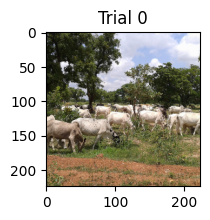

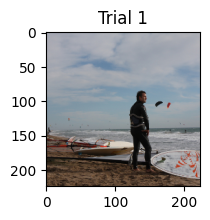

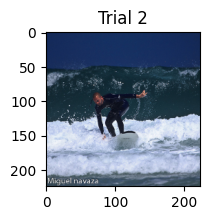

In [9]:
print("Loading all images seen by NSD subj01 in order of presentation (will take a minute)")

# load coco 73k indices for subj01
hdf5_file = h5py.File("COCO_73k_subj_indices.hdf5", "r")
indices = hdf5_file["subj01"][:] 

f = h5py.File(f'/weka/proj-medarc/shared/mindeyev2_dataset/coco_images_224_float16.hdf5', 'r')
coco73k_images = f['images']
nsd_images = np.stack([coco73k_images[idx] for idx in indices]) # this is slow because hdf5 files have strict indexing requirements 
nsd_images = nsd_images.astype(np.float32) # matplotlib doesnt like displaying float16 images
print("nsd_images", nsd_images.shape)

plt.figure(figsize=(2,2))
plt.imshow(np.transpose(nsd_images[0], (1, 2, 0)))
plt.title(f"Trial 0")
plt.show()
plt.figure(figsize=(2,2))
plt.imshow(np.transpose(nsd_images[1], (1, 2, 0)))
plt.title(f"Trial 1")
plt.show()
plt.figure(figsize=(2,2))
plt.imshow(np.transpose(nsd_images[2], (1, 2, 0)))
plt.title(f"Trial 2")
plt.show()

## Load GLMSingle voxel data

In [10]:
print("Loading concatenated nsdgeneral voxels from all betas_sessions for NSD subj01")

try:
    with h5py.File('nsd_voxels.hdf5', 'r') as file:
        nsd_vox = file['subj01'][:] # (30000, 15724)
    print("nsd_vox", nsd_vox.shape)

    nsd_vox = zscore(nsd_vox)
    print("voxels have been zscored")
    print(nsd_vox[:,0].mean(), nsd_vox[:,0].std())
except:
    raise Exception("nsd_voxels.hdf5 not found!\n Below code was used to create the file.")
    nsd_voxels = None
    for session in tqdm(range(1,41)):
        temp_nsd_vox = nib.load(f"nsd_subj01/betas_session{session:02d}.nii.gz").get_fdata()
        temp_nsd_vox = np.moveaxis(temp_nsd_vox, (0,1,2,3), (1,2,3,0))
        roi = nib.load("nsdgeneral.nii.gz").get_fdata()
        roi[roi!=1] = 0
        temp_nsd_vox = temp_nsd_vox[:,roi.astype(bool)]
        nsd_voxels = temp_nsd_vox if nsd_voxels is None else np.vstack((nsd_voxels, temp_nsd_vox))
    print("nsd_voxels", nsd_voxels.shape)
    
    with h5py.File('nsd_voxels.hdf5', 'w') as file:
        file.create_dataset('subj01', data=nsd_voxels)

Loading concatenated nsdgeneral voxels from all betas_sessions for NSD subj01
nsd_vox (30000, 15724)
voxels have been zscored
2.6526928801710407e-17 0.9999999980682533


# Subset only the samples where images were seen by both sub-001 and NSD subj01

In [16]:
print("Loading only the NSD subj01 voxels/images for the images that were seen by our sub-001 (in same order)")

comparison_vox = vox0.transpose(0,2,1) # (150, 2, 18419)
comparison_images = images[pairs[:,0]] # torch.Size([150, 3, 224, 224])

try:
    nsd_comparison_vox = np.load("nsd_comparison_vox.npy")
    nsd_comparison_images = np.load("nsd_comparison_images.npy")
except:
    raise Exception("Files not found!\n Below code was used to create the files.")

    nsd_comparison_vox = np.zeros((len(comparison_images), 2, nsd_vox.shape[-1]))
    nsd_comparison_images = np.zeros_like(comparison_images)
    
    shared_cnt = 0
    unshared_cnt = 0
    no2ndk = 0
    shared_occurrences = {}
    for ours_i in tqdm(range(len(comparison_images))):
        kk = 0
        for nsd_i in range(len(nsd_images)):        
            if torch.sum(torch.abs(comparison_images[ours_i] - nsd_images[nsd_i])) < 2500:
                if kk==0:
                    shared_cnt += 1
                nsd_comparison_vox[ours_i,kk] = nsd_vox[nsd_i]
                nsd_comparison_images[ours_i] = comparison_images[ours_i]
                kk += 1
                if kk > 1:
                    break
            if nsd_i==len(nsd_images)-1:
                unshared_cnt += 1
                if kk==1:
                    no2ndk += 1
    
    print("shared_cnt", shared_cnt)
    print("unshared_cnt", unshared_cnt)
    print("no2ndk", no2ndk)
    
    np.save("raw_nsd_comparison_vox.npy", nsd_comparison_vox) # (150, 2, 15724)
    np.save("nsd_comparison_images.npy", nsd_comparison_images) # (150, 3, 224, 224)

Loading only the NSD subj01 voxels/images for the images that were seen by our sub-001 (in same order)


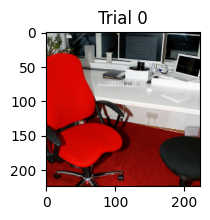

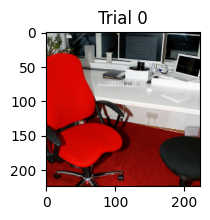

In [37]:
# checking that comparison_images is identical to nsd_comparison_images
plt.figure(figsize=(2,2))
plt.imshow(np.transpose(comparison_images[0].numpy(), (1, 2, 0)))
plt.title(f"Trial 0")
plt.show()
plt.figure(figsize=(2,2))
plt.imshow(np.transpose(nsd_comparison_images[0], (1, 2, 0)))
plt.title(f"Trial 0")
plt.show()

## Reliability calculation

### Calculate reliability (corr between first and second presentation of same image) for every voxel

In [46]:
nsd_rels = np.full(nsd_comparison_vox.shape[-1],np.nan)
for v in tqdm(range(nsd_comparison_vox.shape[-1])):
    nsd_rels[v] = np.corrcoef(nsd_comparison_vox[:,0,v], 
                              nsd_comparison_vox[:,1,v])[1,0]
print("nsd_rels", nsd_rels.shape)

100%|██████████████████████████████████| 15724/15724 [00:00<00:00, 21880.85it/s]

nsd_rels (15724,)


In [51]:
nsd_comparison_vox.shape

(150, 2, 15724)

### Create representational similarity matrix

In [55]:
nsd_vox_avg = nsd_comparison_vox.mean(1)

# Masking RDM for each reliability threshold
r_thresholds = np.array([.0, .1, .2, .3])
nsd_rdm = np.zeros((len(r_thresholds), len(pairs), len(pairs))) 
for ir_thresh, r_thresh in enumerate(r_thresholds):
    print(f"reliability threshold = {r_thresh}")
    for i in tqdm(range(len(pairs))):
        for j in range(len(pairs)):
            nsd_rdm[ir_thresh,i,j] = np.corrcoef(nsd_vox_avg[i,nsd_rels>r_thresh], 
                                             nsd_vox_avg[j,nsd_rels>r_thresh])[0,1]
# nsd_rdm is shape (4, 150, 150)

reliability threshold = 0.0


100%|█████████████████████████████████████████| 150/150 [00:04<00:00, 30.18it/s]


reliability threshold = 0.1


100%|█████████████████████████████████████████| 150/150 [00:04<00:00, 35.16it/s]


reliability threshold = 0.2


100%|█████████████████████████████████████████| 150/150 [00:03<00:00, 46.04it/s]


reliability threshold = 0.3


100%|█████████████████████████████████████████| 150/150 [00:02<00:00, 55.84it/s]


# Visualize RDMs

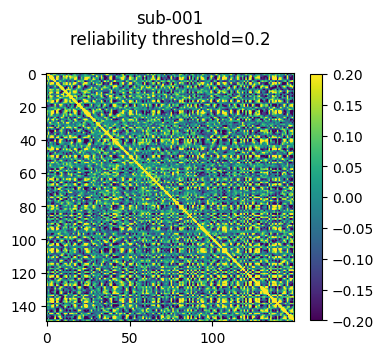

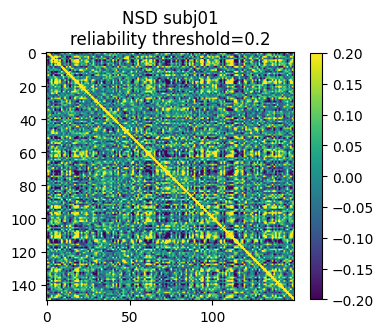

[0.01165137 0.00840421 0.00411369 0.0028651 ]


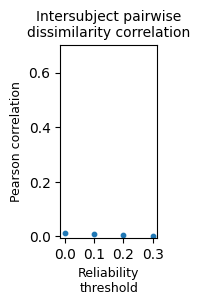

In [58]:
reliability_threshold_to_visualize = .2

plt.figure(figsize=(4,4))
plt.imshow(rdm[np.where(r_thresholds==reliability_threshold_to_visualize)[0].item()], clim=(-.2,.2))
plt.colorbar(shrink=0.8)
plt.title(f"sub-001\nreliability threshold={reliability_threshold_to_visualize}\n")
plt.show()

plt.figure(figsize=(4,4))
plt.imshow(nsd_rdm[np.where(r_thresholds==reliability_threshold_to_visualize)[0].item()], clim=(-.2,.2))
plt.colorbar(shrink=0.8)
plt.title(f"NSD subj01\nreliability threshold={reliability_threshold_to_visualize}")
plt.show()

intersubject_corrs = np.zeros((len(r_thresholds)))
for ir_thresh, r_thresh in enumerate(r_thresholds):
    lower_triangle_indices = np.tril_indices(150, k=-1) # excludes diagonal
    tril_ours = rdm[ir_thresh][lower_triangle_indices]
    tril_nsd = nsd_rdm[ir_thresh][lower_triangle_indices]
    
    intersubject_corrs[ir_thresh] = np.corrcoef((tril_ours, tril_nsd))[0,1]

print(intersubject_corrs)
plt.figure(figsize=(1.25,2.5))
plt.scatter(r_thresholds,intersubject_corrs, s=10)
plt.ylabel("Pearson correlation", fontsize=9)
plt.ylim(-0.005,.7)
plt.xlabel("Reliability\nthreshold", fontsize=9)
plt.xticks(r_thresholds)
plt.title("Intersubject pairwise\ndissimilarity correlation", fontsize=10)
plt.show()

In [551]:
# Calculate pairwise distances for paired indices
paired_distances = None
for pair in tqdm(pairs):
    idx1, idx2 = pair
    if paired_distances is None:
        paired_distances = torch.abs(vox[idx1] - vox[idx2])[None]
    else:
        paired_distances = torch.vstack((paired_distances, torch.abs(vox[idx1] - vox[idx2])[None]))

# Calculate pairwise distances for unpaired indices
unpaired_distances = None
for i in range(len(vox)):
    for j in range(i + 1, len(vox)):
        if unpaired_distances is not None:
            if len(unpaired_distances) == len(paired_distances):
                break
        if [i, j] not in pairs and [j, i] not in pairs:
            if unpaired_distances is None:
                unpaired_distances = torch.abs(vox[i] - vox[j])[None]
            else:
                unpaired_distances = torch.vstack((unpaired_distances, torch.abs(vox[i] - vox[j])[None]))

# Calculate mean distances
mean_paired_distance = torch.median(paired_distances, dim=0).values
mean_unpaired_distance = torch.median(unpaired_distances, dim=0).values

# Calculate reliability metric for each voxel
reliability_metric = mean_unpaired_distance - mean_paired_distance

print(reliability_metric)

100%|███████████████████████████████████████| 181/181 [00:00<00:00, 3041.59it/s]

tensor([ 0.0720, -0.1333,  0.7357,  ..., -0.4051, -0.2543, -0.2446])


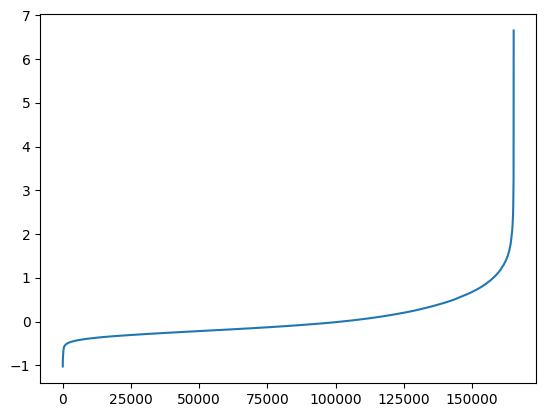

tensor(68)


In [426]:
plt.plot(np.sort(reliability_metric.cpu().numpy()))
plt.show()

subset = reliability_metric>3
print(subset.sum())

# Training MindEye

In [359]:
# train on NSD
images = np.vstack((nsd_comparison_images, nsd_comparison_images))
vox = np.vstack((nsd_comparison_vox[:,0,:], nsd_comparison_vox[:,1,:]))

# train on Princeton
images = np.vstack((comparison_images, comparison_images))
vox = np.vstack((vox0[:,:,0], vox0[:,:,1]))

In [360]:
# # Reliability thresholding?
# vox = vox[:,rels>.2]

In [361]:
print(images.shape)
print(vox.shape)

(300, 3, 224, 224)
(300, 18419)


In [362]:
images = torch.Tensor(images)
vox = torch.Tensor(vox)

In [363]:
utils.seed_everything(0)

all_indices = np.random.permutation(np.arange(len(images)))
print(len(all_indices))
train_image_indices = all_indices[:int(len(images)*.8)]
test_image_indices = all_indices[int(len(images)*.8):]
print(len(train_image_indices), len(test_image_indices))

300
240 60


In [364]:
### Multi-GPU config ###
from accelerate import Accelerator, DeepSpeedPlugin

local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

data_type = torch.float32 # change depending on your mixed_precision

accelerator = Accelerator(split_batches=False)# mixed_precision="fp16") # ['no', 'fp8', 'fp16', 'bf16']
batch_size = 24

LOCAL RANK  0


In [365]:
print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
num_devices = torch.cuda.device_count()
global_batch_size = batch_size * num_devices
print("global_batch_size", global_batch_size)
if num_devices==0 or not distributed: num_devices = 1
num_workers = num_devices
print(accelerator.state)

# set data_type to match your mixed precision (automatically set based on deepspeed config)
if accelerator.mixed_precision == "bf16":
    data_type = torch.bfloat16
elif accelerator.mixed_precision == "fp16":
    data_type = torch.float16
else:
    data_type = torch.float32

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)
print = accelerator.print # only print if local_rank=0

PID of this process = 3655933
device: cuda
global_batch_size 24
Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

distributed = False num_devices = 1 local rank = 0 world size = 1 data_type = torch.float32


## Configurations

In [366]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = "testing"
    print("model_name:", model_name)
    
    # global_batch_size and batch_size should already be defined in the above cells
    # other variables can be specified in the following string:
    jupyter_args = f"--data_path=/weka/proj-fmri/shared/mindeyev2_dataset \
                    --model_name={model_name} \
                    --no-multi_subject --subj=1 --batch_size={batch_size} \
                    --hidden_dim=512 --clip_scale=1. \
                    --no-blurry_recon --blur_scale=.5  \
                    --no-use_prior --prior_scale=30 --no-visualize_prior \
                    --n_blocks=4 --max_lr=3e-5 --mixup_pct=.33 --num_epochs=30 --no-use_image_aug \
                    --ckpt_interval=999 --no-ckpt_saving --no-wandb_log --new_test"# \
                    # --multisubject_ckpt=/weka/proj-fmri/paulscotti/MindEye2_git/train_logs/final_subj01_pretrained_40sess_24bs"
    # --multisubject_ckpt=../../train_logs/multisubject_subj01_1024hid_nolow_300ep_seed0"
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: testing
--data_path=/weka/proj-fmri/shared/mindeyev2_dataset                     --model_name=testing                     --no-multi_subject --subj=1 --batch_size=24                     --hidden_dim=512 --clip_scale=1.                     --no-blurry_recon --blur_scale=.5                      --no-use_prior --prior_scale=30 --no-visualize_prior                     --n_blocks=4 --max_lr=3e-5 --mixup_pct=.33 --num_epochs=30 --no-use_image_aug                     --ckpt_interval=999 --no-ckpt_saving --no-wandb_log --new_test
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [367]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--data_path", type=str, default="/weka/proj-fmri/shared/natural-scenes-dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8],
    help="Validate on which subject?",
)
parser.add_argument(
    "--multisubject_ckpt", type=str, default=None,
    help="Path to pre-trained multisubject model to finetune a single subject from. multisubject must be False.",
)
parser.add_argument(
    "--num_sessions", type=int, default=0,
    help="Number of training sessions to include (if multi_subject, this variable doesnt matter)",
)
parser.add_argument(
    "--use_prior",action=argparse.BooleanOptionalAction,default=False,
    help="whether to train diffusion prior (True) or just rely on retrieval part of the pipeline (False)",
)
parser.add_argument(
    "--visualize_prior",action=argparse.BooleanOptionalAction,default=False,
    help="output visualizations from unCLIP every ckpt_interval (requires more memory!)",
)
parser.add_argument(
    "--batch_size", type=int, default=32,
    help="Batch size can be increased by 10x if only training v2c and not diffusion diffuser",
)
parser.add_argument(
    "--wandb_log",action=argparse.BooleanOptionalAction,default=False,
    help="whether to log to wandb",
)
parser.add_argument(
    "--resume_from_ckpt",action=argparse.BooleanOptionalAction,default=False,
    help="if not using wandb and want to resume from a ckpt",
)
parser.add_argument(
    "--wandb_project",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--mixup_pct",type=float,default=.33,
    help="proportion of way through training when to switch from BiMixCo to SoftCLIP",
)
parser.add_argument(
    "--low_mem",action=argparse.BooleanOptionalAction,default=False,
    help="whether to preload images to cpu to speed things up but consume more memory",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
    help="whether to output blurry reconstructions",
)
parser.add_argument(
    "--blur_scale",type=float,default=.5,
    help="multiply loss from blurry recons by this number",
)
parser.add_argument(
    "--clip_scale",type=float,default=1.,
    help="multiply contrastive loss by this number",
)
parser.add_argument(
    "--prior_scale",type=float,default=30,
    help="multiply diffusion prior loss by this",
)
parser.add_argument(
    "--use_image_aug",action=argparse.BooleanOptionalAction,default=True,
    help="whether to use image augmentation",
)
parser.add_argument(
    "--num_epochs",type=int,default=120,
    help="number of epochs of training",
)
parser.add_argument(
    "--multi_subject",action=argparse.BooleanOptionalAction,default=False,
)
parser.add_argument(
    "--new_test",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--n_blocks",type=int,default=2,
)
parser.add_argument(
    "--hidden_dim",type=int,default=1024,
)
parser.add_argument(
    "--seq_past",type=int,default=0,
)
parser.add_argument(
    "--seq_future",type=int,default=0,
)
parser.add_argument(
    "--lr_scheduler_type",type=str,default='cycle',choices=['cycle','linear'],
)
parser.add_argument(
    "--ckpt_saving",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--ckpt_interval",type=int,default=5,
    help="save backup ckpt and reconstruct every x epochs",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--max_lr",type=float,default=3e-4,
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# seed all random functions
utils.seed_everything(seed)

outdir = os.path.abspath(f'../../train_logs/{model_name}')
if not os.path.exists(outdir) and ckpt_saving:
    os.makedirs(outdir,exist_ok=True)
    
if use_image_aug or blurry_recon:
    import kornia
    import kornia.augmentation as K
    from kornia.augmentation.container import AugmentationSequential
if use_image_aug:
    img_augment = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )
    # Define the blurring augmentations
    blur_augment = K.RandomGaussianBlur(kernel_size=(21, 21), sigma=(51.0, 51.0), p=1.)
    
if multi_subject:
    subj_list = np.arange(1,9)
    subj_list = subj_list[subj_list != subj]
else:
    subj_list = [subj]

print("subj_list", subj_list, "num_sessions", num_sessions)

subj_list [1] num_sessions 0


## Prep data, models, and dataloaders

### Creating wds dataloader, preload betas and all 73k possible images

In [368]:
def my_split_by_node(urls): return urls
num_voxels_list = []

if multi_subject:
    nsessions_allsubj=np.array([40, 40, 32, 30, 40, 32, 40, 30])
    num_samples_per_epoch = (750*40) // num_devices 
else:
    # num_samples_per_epoch = (750*num_sessions) // num_devices 
    num_samples_per_epoch = len(train_image_indices)

print("dividing batch size by subj_list, which will then be concatenated across subj during training...") 
batch_size = batch_size // len(subj_list)

num_iterations_per_epoch = num_samples_per_epoch // (batch_size*len(subj_list))

print("batch_size =", batch_size, "num_iterations_per_epoch =",num_iterations_per_epoch, "num_samples_per_epoch =",num_samples_per_epoch)

dividing batch size by subj_list, which will then be concatenated across subj during training...
batch_size = 24 num_iterations_per_epoch = 10 num_samples_per_epoch = 240


In [369]:
train_data = {}
train_dl = {}

train_data[f'subj0{subj}'] = torch.utils.data.TensorDataset(torch.tensor(train_image_indices))

test_data = torch.utils.data.TensorDataset(torch.tensor(test_image_indices))

In [370]:
num_voxels = {}
voxels = {}
for s in subj_list:
    print(f"Training with {num_sessions} sessions")
    train_dl = torch.utils.data.DataLoader(train_data[f'subj0{s}'], batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)

    num_voxels_list.append(vox[0].shape[-1])
    num_voxels[f'subj0{s}'] = vox[0].shape[-1]
    voxels[f'subj0{s}'] = vox
    print(f"num_voxels for subj0{s}: {num_voxels[f'subj0{s}']}")

print("Loaded all subj train dls and vox!\n")

# Validate only on one subject
if multi_subject: 
    subj = subj_list[0] # cant validate on the actual held out person so picking first in subj_list
num_test = len(test_image_indices) # 100
test_dl = torch.utils.data.DataLoader(test_data, batch_size=24, shuffle=False, drop_last=True, pin_memory=True)

print(f"Loaded test dl for subj{subj}!\n")

seq_len = seq_past + 1 + seq_future
print(f"currently using {seq_len} seq_len (chose {seq_past} past behav and {seq_future} future behav)")

Training with 0 sessions
num_voxels for subj01: 18419
Loaded all subj train dls and vox!

Loaded test dl for subj1!

currently using 1 seq_len (chose 0 past behav and 0 future behav)


## Load models

### CLIP image embeddings  model

In [371]:
## USING OpenCLIP ViT-bigG ###
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder
# from generative_models.sgm.models.diffusion import DiffusionEngine
# from omegaconf import OmegaConf

try:
    print(clip_img_embedder)
except:
    clip_img_embedder = FrozenOpenCLIPImageEmbedder(
        arch="ViT-bigG-14",
        version="laion2b_s39b_b160k",
        output_tokens=True,
        only_tokens=True,
    )
    clip_img_embedder.to(device)
clip_seq_dim = 256
clip_emb_dim = 1664

### USING OPEN AI CLIP ViT-L ###
# import clip
# clip_model, preprocess = clip.load("ViT-L/14", device=device)
# preprocess = transforms.Compose([
#     transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
#     transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
#                          std=[0.26862954, 0.26130258, 0.27577711]),
# ])
# def clip_img_embedder(image):
#     preproc_img = preprocess(image)
#     return clip_model.encode_image(preproc_img)
# clip_seq_dim = 1
# clip_emb_dim = 768

FrozenOpenCLIPImageEmbedder(
  (model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 1664, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-47): 48 x ResidualAttentionBlock(
            (ln_1): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1664, out_features=1664, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1664, out_features=8192, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=8192, out_features=1664, bias=True)
            )
            (ls_2): Identity()


### MindEye modules

In [372]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()
model

MindEyeModule()

In [373]:
class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_sizes, out_features, seq_len): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    def forward(self, x, subj_idx=0):
        out = torch.cat([self.linears[subj_idx](x[:,seq]).unsqueeze(1) for seq in range(seq_len)], dim=1)
        return out
        
model.ridge = RidgeRegression(num_voxels_list, out_features=hidden_dim, seq_len=seq_len)
utils.count_params(model.ridge)
utils.count_params(model)

# test on subject 1 with fake data
b = torch.randn((2,seq_len,num_voxels_list[0]))
print(b.shape, model.ridge(b,0).shape)

param counts:
9,431,040 total
9,431,040 trainable
param counts:
9,431,040 total
9,431,040 trainable
torch.Size([2, 1, 18419]) torch.Size([2, 1, 512])


In [374]:
from functools import partial
from diffusers.models.vae import Decoder
class BrainNetwork(nn.Module):
    def __init__(self, h=4096, in_dim=15724, out_dim=768, seq_len=2, n_blocks=n_blocks, drop=.15, 
                 clip_size=768):
        super().__init__()
        self.seq_len = seq_len
        self.h = h
        self.clip_size = clip_size
        
        self.mixer_blocks1 = nn.ModuleList([
            self.mixer_block1(h, drop) for _ in range(n_blocks)
        ])
        self.mixer_blocks2 = nn.ModuleList([
            self.mixer_block2(seq_len, drop) for _ in range(n_blocks)
        ])
        
        # Output linear layer
        self.backbone_linear = nn.Linear(h * seq_len, out_dim, bias=True) 
        if clip_scale>0:
            self.clip_proj = self.projector(clip_size, clip_size, h=clip_size)
            
    def projector(self, in_dim, out_dim, h=2048):
        return nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.GELU(),
            nn.Linear(in_dim, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, out_dim)
        )
    
    def mlp(self, in_dim, out_dim, drop):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(out_dim, out_dim),
        )
    
    def mixer_block1(self, h, drop):
        return nn.Sequential(
            nn.LayerNorm(h),
            self.mlp(h, h, drop),  # Token mixing
        )

    def mixer_block2(self, seq_len, drop):
        return nn.Sequential(
            nn.LayerNorm(seq_len),
            self.mlp(seq_len, seq_len, drop)  # Channel mixing
        )
        
    def forward(self, x):
        # make empty tensors
        c,b = torch.Tensor([0.]), torch.Tensor([[0.],[0.]])
        
        # Mixer blocks
        residual1 = x
        residual2 = x.permute(0,2,1)
        for block1, block2 in zip(self.mixer_blocks1,self.mixer_blocks2):
            x = block1(x) + residual1
            residual1 = x
            x = x.permute(0,2,1)
            
            x = block2(x) + residual2
            residual2 = x
            x = x.permute(0,2,1)
            
        x = x.reshape(x.size(0), -1)
        backbone = self.backbone_linear(x).reshape(len(x), -1, self.clip_size)
        if clip_scale>0:
            c = self.clip_proj(backbone)
        
        return backbone, c, b

model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=seq_len, 
                          clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim)
utils.count_params(model.backbone)
utils.count_params(model)

# test that the model works on some fake data
b = torch.randn((2,seq_len,hidden_dim))
print("b.shape",b.shape)

backbone_, clip_, blur_ = model.backbone(b)
print(backbone_.shape, clip_.shape, blur_[0].shape, blur_[1].shape)

param counts:
228,956,824 total
228,956,824 trainable
param counts:
238,387,864 total
238,387,864 trainable
b.shape torch.Size([2, 1, 512])
torch.Size([2, 256, 1664]) torch.Size([2, 256, 1664]) torch.Size([1]) torch.Size([1])


### Adding diffusion prior + unCLIP if use_prior=True

In [375]:
if use_prior:
    from models import *

    # setup diffusion prior network
    out_dim = clip_emb_dim
    depth = 6
    dim_head = 52
    heads = clip_emb_dim//52 # heads * dim_head = clip_emb_dim
    timesteps = 100

    prior_network = VersatileDiffusionPriorNetwork(
            dim=out_dim,
            depth=depth,
            dim_head=dim_head,
            heads=heads,
            causal=False,
            num_tokens = clip_seq_dim,
            learned_query_mode="pos_emb"
        )

    model.diffusion_prior = BrainDiffusionPrior(
        net=prior_network,
        image_embed_dim=out_dim,
        condition_on_text_encodings=False,
        timesteps=timesteps,
        cond_drop_prob=0.2,
        image_embed_scale=None,
    )
    
    utils.count_params(model.diffusion_prior)
    utils.count_params(model)
    
    # prep unCLIP
    if visualize_prior:
        config = OmegaConf.load("generative_models/configs/unclip6.yaml")
        config = OmegaConf.to_container(config, resolve=True)
        unclip_params = config["model"]["params"]
        network_config = unclip_params["network_config"]
        denoiser_config = unclip_params["denoiser_config"]
        first_stage_config = unclip_params["first_stage_config"]
        conditioner_config = unclip_params["conditioner_config"]
        sampler_config = unclip_params["sampler_config"]
        scale_factor = unclip_params["scale_factor"]
        disable_first_stage_autocast = unclip_params["disable_first_stage_autocast"]
        offset_noise_level = unclip_params["loss_fn_config"]["params"]["offset_noise_level"]

        first_stage_config['target'] = 'sgm.models.autoencoder.AutoencoderKL'
        sampler_config['params']['num_steps'] = 38

        diffusion_engine = DiffusionEngine(network_config=network_config,
                               denoiser_config=denoiser_config,
                               first_stage_config=first_stage_config,
                               conditioner_config=conditioner_config,
                               sampler_config=sampler_config,
                               scale_factor=scale_factor,
                               disable_first_stage_autocast=disable_first_stage_autocast)
        # set to inference
        diffusion_engine.eval().requires_grad_(False)
        diffusion_engine.to(device)

        ckpt_path = '/weka/proj-fmri/shared/mindeyev2_dataset/unclip6_epoch0_step110000.ckpt'
        ckpt = torch.load(ckpt_path, map_location='cpu')
        diffusion_engine.load_state_dict(ckpt['state_dict'])

        image = images[:1].to(device)
        batch={"jpg": image,
              "original_size_as_tuple": torch.ones(image.shape[0], 2).to(device) * 768,
              "crop_coords_top_left": torch.zeros(image.shape[0], 2).to(device)}
        out = diffusion_engine.conditioner(batch)
        vector_suffix = out["vector"].to(device)
        print("vector_suffix", vector_suffix.shape)

### Setup optimizer / lr / ckpt saving

In [376]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

opt_grouped_parameters = [
    {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

if use_prior:
    opt_grouped_parameters.extend([
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ])

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

if lr_scheduler_type == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=int(np.floor(num_epochs*num_iterations_per_epoch)),
        last_epoch=-1
    )
elif lr_scheduler_type == 'cycle':
    total_steps=int(np.floor(num_epochs*num_iterations_per_epoch))
    print("total_steps", total_steps)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=max_lr,
        total_steps=total_steps,
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/num_epochs
    )
    
def save_ckpt(tag):
    ckpt_path = outdir+f'/{tag}.pth'
    if accelerator.is_main_process:
        unwrapped_model = accelerator.unwrap_model(model)
        torch.save({
            'epoch': epoch,
            'model_state_dict': unwrapped_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'train_losses': losses,
            'test_losses': test_losses,
            'lrs': lrs,
            }, ckpt_path)
    print(f"\n---saved {outdir}/{tag} ckpt!---\n")

def load_ckpt(tag,load_lr=True,load_optimizer=True,load_epoch=True,strict=True,outdir=outdir,multisubj_loading=False): 
    print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")
    checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
    state_dict = checkpoint['model_state_dict']
    if multisubj_loading: # remove incompatible ridge layer that will otherwise error
        state_dict.pop('ridge.linears.0.weight',None)
    model.load_state_dict(state_dict, strict=strict)
    if load_epoch:
        globals()["epoch"] = checkpoint['epoch']
        print("Epoch",epoch)
    if load_optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if load_lr:
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    del checkpoint

print("\nDone with model preparations!")
num_params = utils.count_params(model)

total_steps 300

Done with model preparations!
param counts:
238,387,864 total
238,387,864 trainable


# Train the model

In [377]:
epoch = 0
losses, test_losses, lrs = [], [], []
best_test_loss = 1e9
torch.cuda.empty_cache()

In [378]:
# load multisubject stage1 ckpt if set
if multisubject_ckpt is not None and not resume_from_ckpt:
    load_ckpt("last",outdir=multisubject_ckpt,load_lr=False,load_optimizer=False,load_epoch=False,strict=False,multisubj_loading=True)

In [379]:
# checkpoint = torch.load(multisubject_ckpt+'/last.pth', map_location='cpu')
# state_dict = checkpoint['model_state_dict']
# model.load_state_dict(state_dict, strict=False)

In [380]:
# train_dls = [train_dl[f'subj0{s}'] for s in subj_list]

model, optimizer, train_dl, lr_scheduler = accelerator.prepare(model, optimizer, train_dl, lr_scheduler)
# leaving out test_dl since we will only have local_rank 0 device do evals

In [381]:
print(f"{model_name} starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))
test_image, test_voxel = None, None
mse = nn.MSELoss()
l1 = nn.L1Loss()
soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))
skip_train = True if epoch>=(num_epochs-1) else False # skip training if you are resuming from a fully trained model

for epoch in progress_bar:
    model.train()

    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    test_fwd_percent_correct = 0.
    test_bwd_percent_correct = 0.
    
    recon_cossim = 0.
    test_recon_cossim = 0.
    recon_mse = 0.
    test_recon_mse = 0.

    loss_clip_total = 0.
    loss_blurry_total = 0.
    loss_blurry_cont_total = 0.
    test_loss_clip_total = 0.
    
    loss_prior_total = 0.
    test_loss_prior_total = 0.

    blurry_pixcorr = 0.
    test_blurry_pixcorr = 0. # needs >.456 to beat low-level subj01 results in mindeye v1

    # you now have voxel_iters and image_iters with num_iterations_per_epoch batches each
    for train_i, behav in enumerate(train_dl):  
        with torch.cuda.amp.autocast(dtype=data_type):
            optimizer.zero_grad()
            loss = 0.
            
            behav = behav[0]

            image = images[behav.long().cpu()].to(device)
            voxel = vox[behav.long().cpu()]
            # voxel = (voxel - train_mean) / train_std
            voxel = torch.Tensor(voxel).unsqueeze(1).to(device)

            if use_image_aug: 
                image = img_augment(image)

            clip_target = clip_img_embedder(image)
            assert not torch.any(torch.isnan(clip_target))

            if epoch < int(mixup_pct * num_epochs):
                voxel, perm, betas, select = utils.mixco(voxel)

            voxel_ridge = model.ridge(voxel,0) #[model.ridge(voxel_list[si],si) for si,s in enumerate(subj_list)]
            # voxel_ridge = torch.cat(voxel_ridge_list, dim=0)

            backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

            if clip_scale>0:
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

            if use_prior:
                loss_prior, prior_out = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                loss_prior_total += loss_prior.item()
                loss_prior *= prior_scale
                loss += loss_prior

                recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target).mean().item()
                recon_mse += mse(prior_out, clip_target).item()

            if clip_scale>0:
                if epoch < int(mixup_pct * num_epochs):                
                    loss_clip = utils.mixco_nce(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006,
                        perm=perm, betas=betas, select=select)
                else:
                    epoch_temp = soft_loss_temps[epoch-int(mixup_pct*num_epochs)]
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=epoch_temp)

                loss_clip_total += loss_clip.item()
                loss_clip *= clip_scale
                loss += loss_clip

            if blurry_recon:     
                image_enc_pred, transformer_feats = blurry_image_enc_

                image_enc = autoenc.encode(2*image-1).latent_dist.mode() * 0.18215
                loss_blurry = l1(image_enc_pred, image_enc)
                loss_blurry_total += loss_blurry.item()

                if epoch < int(mixup_pct * num_epochs):
                    image_enc_shuf = image_enc[perm]
                    betas_shape = [-1] + [1]*(len(image_enc.shape)-1)
                    image_enc[select] = image_enc[select] * betas[select].reshape(*betas_shape) + \
                        image_enc_shuf[select] * (1 - betas[select]).reshape(*betas_shape)

                image_norm = (image - mean)/std
                image_aug = (blur_augs(image) - mean)/std
                _, cnx_embeds = cnx(image_norm)
                _, cnx_aug_embeds = cnx(image_aug)

                cont_loss = utils.soft_cont_loss(
                    nn.functional.normalize(transformer_feats.reshape(-1, transformer_feats.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_aug_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    temp=0.2)
                loss_blurry_cont_total += cont_loss.item()

                loss += (loss_blurry + 0.1*cont_loss) * blur_scale #/.18215

            if clip_scale>0:
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

            if blurry_recon:
                with torch.no_grad():
                    # only doing pixcorr eval on a subset of the samples per batch because its costly & slow to compute autoenc.decode()
                    random_samps = np.random.choice(np.arange(len(image)), size=len(image)//5, replace=False)
                    blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample/ 2 + 0.5).clamp(0,1)
                    pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    blurry_pixcorr += pixcorr.item()
            
            utils.check_loss(loss)
            accelerator.backward(loss)
            optimizer.step()

            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])

            if lr_scheduler_type is not None:
                lr_scheduler.step()
                
            if train_i >= num_iterations_per_epoch-1:
                break
                
    model.eval()
    if local_rank==0:
        with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type): 
            for test_i, behav in enumerate(test_dl):  
                behav = behav[0]
                # assert len(behav) == num_test

                loss=0.
                
                image = images[behav.long().cpu()].to(device)
                voxel = vox[behav.long().cpu()]
                # voxel = (voxel - train_mean) / train_std
                voxel = torch.Tensor(voxel).unsqueeze(1).to(device)
                
                if use_image_aug: 
                    image = img_augment(image)

                clip_target = clip_img_embedder(image.float())
                
                voxel_ridge = model.ridge(voxel,0)

                backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

                if clip_scale>0:
                    clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                    clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
                
                # for some evals, only doing a subset of the samples per batch because of computational cost
                random_samps = np.random.choice(np.arange(len(image)), size=len(image)//5, replace=False)
                
                if use_prior:
                    loss_prior, contaminated_prior_out = model.diffusion_prior(text_embed=backbone[random_samps], image_embed=clip_target[random_samps])
                    test_loss_prior_total += loss_prior.item()
                    loss_prior *= prior_scale
                    loss += loss_prior
                    
                    if visualize_prior:
                        # now get unCLIP prediction without feeding it the image embed to get uncontaminated reconstruction
                        prior_out = model.diffusion_prior.p_sample_loop(backbone[random_samps].shape, 
                                        text_cond = dict(text_embed = backbone[random_samps]), 
                                        cond_scale = 1., timesteps = timesteps)

                        test_recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target[random_samps]).mean().item()
                        test_recon_mse += mse(prior_out, clip_target[random_samps]).item()
                        
                if clip_scale>0:
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006)

                    test_loss_clip_total += loss_clip.item()
                    loss_clip = loss_clip * clip_scale
                    loss += loss_clip

                if blurry_recon:
                    image_enc_pred, _ = blurry_image_enc_
                    blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample / 2 + 0.5).clamp(0,1)
                    pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    test_blurry_pixcorr += pixcorr.item()

                if clip_scale>0:
                    # forward and backward top 1 accuracy        
                    labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                    test_fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                    test_bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()
                
                utils.check_loss(loss)                
                test_losses.append(loss.item())

            # if utils.is_interactive(): clear_output(wait=True)
            if skip_train: break
            print("---")

            # assert (test_i+1) == 1
            logs = {"train/loss": np.mean(losses[-(train_i+1):]),
                "test/loss": np.mean(test_losses[-(test_i+1):]),
                "train/lr": lrs[-1],
                "train/num_steps": len(losses),
                "test/num_steps": len(test_losses),
                "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
                "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
                "test/test_fwd_pct_correct": test_fwd_percent_correct / (test_i + 1),
                "test/test_bwd_pct_correct": test_bwd_percent_correct / (test_i + 1),
                "train/loss_clip_total": loss_clip_total / (train_i + 1),
                "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
                "train/loss_blurry_cont_total": loss_blurry_cont_total / (train_i + 1),
                "test/loss_clip_total": test_loss_clip_total / (test_i + 1),
                "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
                "test/blurry_pixcorr": test_blurry_pixcorr / (test_i + 1),
                "train/recon_cossim": recon_cossim / (train_i + 1),
                "test/recon_cossim": test_recon_cossim / (test_i + 1),
                "train/recon_mse": recon_mse / (train_i + 1),
                "test/recon_mse": test_recon_mse / (test_i + 1),
                "train/loss_prior": loss_prior_total / (train_i + 1),
                "test/loss_prior": test_loss_prior_total / (test_i + 1),
                }

            # if finished training, save jpg recons if they exist
            if (epoch == num_epochs-1) or (epoch % ckpt_interval == 0):
                if blurry_recon:    
                    image_enc = autoenc.encode(2*image[:4]-1).latent_dist.mode() * 0.18215
                    # transform blurry recon latents to images and plot it
                    fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                    jj=-1
                    for j in [0,1,2,3]:
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc_pred[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')

                    plt.show()
                        
                if use_prior and visualize_prior: # output recons every ckpt
                    idx = np.random.randint(0, 3)
                    print(f"reconstructing... idx={idx}")
                    samples = utils.unclip_recon(prior_out[[idx]],
                             diffusion_engine,
                             vector_suffix)
                    if utils.is_interactive():
                        plt.figure(figsize=(2,2))
                        plt.imshow(transforms.ToPILImage()(image[idx]))
                        plt.axis('off')
                        plt.show()
                        
                        plt.figure(figsize=(2,2))
                        plt.imshow(transforms.ToPILImage()(samples[0]))
                        plt.axis('off')
                        plt.show()

            progress_bar.set_postfix(**logs)
            
    # Save model checkpoint and reconstruct
    if (ckpt_saving) and (epoch % ckpt_interval == 0):
        save_ckpt(f'last')

    # wait for other GPUs to catch up if needed
    accelerator.wait_for_everyone()
    torch.cuda.empty_cache()

print("\n===Finished!===\n")
if ckpt_saving:
    save_ckpt(f'last')

testing starting with epoch 0 / 30


  3%|██████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 1/30 [00:01<00:49,  1.70s/it, test/blurry_pixcorr=0, test/loss=3.25, test/loss_clip_total=3.25, test/loss_prior=0, test/num_steps=2, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0625, test/test_fwd_pct_correct=0.0625, train/blurry_pixcorr=0, train/bwd_pct_correct=0.0375, train/fwd_pct_correct=0.0417, tr

---


  7%|████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 2/30 [00:03<00:47,  1.69s/it, test/blurry_pixcorr=0, test/loss=3.21, test/loss_clip_total=3.21, test/loss_prior=0, test/num_steps=4, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0417, test/test_fwd_pct_correct=0.0833, train/blurry_pixcorr=0, train/bwd_pct_correct=0.1, train/fwd_pct_correct=0.404,

---


 10%|███████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 3/30 [00:05<00:45,  1.69s/it, test/blurry_pixcorr=0, test/loss=3.21, test/loss_clip_total=3.21, test/loss_prior=0, test/num_steps=6, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0625, test/test_fwd_pct_correct=0.104, train/blurry_pixcorr=0, train/bwd_pct_correct=0.363, train/fwd_pct_correct=0.675, tr

---


 13%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 4/30 [00:06<00:43,  1.69s/it, test/blurry_pixcorr=0, test/loss=3.24, test/loss_clip_total=3.24, test/loss_prior=0, test/num_steps=8, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0625, test/test_fwd_pct_correct=0.0833, train/blurry_pixcorr=0, train/bwd_pct_correct=0.471, train/fwd_pct_correct=0.696, tr

---


 13%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 4/30 [00:08<00:43,  1.69s/it, test/blurry_pixcorr=0, test/loss=3.17, test/loss_clip_total=3.17, test/loss_prior=0, test/num_steps=10, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0417, test/test_fwd_pct_correct=0.0833, train/blurry_pixcorr=0, train/bwd_pct_correct=0.579, train/fwd_pct_correct=0.704, tr

---


 20%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 6/30 [00:11<00:47,  1.98s/it, test/blurry_pixcorr=0, test/loss=3.09, test/loss_clip_total=3.09, test/loss_prior=0, test/num_steps=12, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.104, test/test_fwd_pct_correct=0.125, train/blurry_pixcorr=0, train/bwd_pct_correct=0.696, train/fwd_pct_correct=0.671, trai

---


 23%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 7/30 [00:13<00:43,  1.90s/it, test/blurry_pixcorr=0, test/loss=3.03, test/loss_clip_total=3.03, test/loss_prior=0, test/num_steps=14, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.104, test/test_fwd_pct_correct=0.146, train/blurry_pixcorr=0, train/bwd_pct_correct=0.763, train/fwd_pct_correct=0.75, trai

---


 27%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 8/30 [00:14<00:40,  1.84s/it, test/blurry_pixcorr=0, test/loss=2.93, test/loss_clip_total=2.93, test/loss_prior=0, test/num_steps=16, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.188, test/test_fwd_pct_correct=0.167, train/blurry_pixcorr=0, train/bwd_pct_correct=0.763, train/fwd_pct_correct=0.729, trai

---


 30%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 9/30 [00:16<00:37,  1.79s/it, test/blurry_pixcorr=0, test/loss=2.89, test/loss_clip_total=2.89, test/loss_prior=0, test/num_steps=18, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.125, test/test_fwd_pct_correct=0.208, train/blurry_pixcorr=0, train/bwd_pct_correct=0.738, train/fwd_pct_correct=0.679, trai

---


 33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 10/30 [00:18<00:35,  1.76s/it, test/blurry_pixcorr=0, test/loss=2.89, test/loss_clip_total=2.89, test/loss_prior=0, test/num_steps=20, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.167, test/test_fwd_pct_correct=0.167, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, train

---


 37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                     | 11/30 [00:19<00:33,  1.74s/it, test/blurry_pixcorr=0, test/loss=2.88, test/loss_clip_total=2.88, test/loss_prior=0, test/num_steps=22, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.167, test/test_fwd_pct_correct=0.167, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, train/

---


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                              | 12/30 [00:21<00:31,  1.74s/it, test/blurry_pixcorr=0, test/loss=2.88, test/loss_clip_total=2.88, test/loss_prior=0, test/num_steps=24, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.167, test/test_fwd_pct_correct=0.167, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, train/l

---


 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                          | 13/30 [00:23<00:29,  1.72s/it, test/blurry_pixcorr=0, test/loss=2.87, test/loss_clip_total=2.87, test/loss_prior=0, test/num_steps=26, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.167, test/test_fwd_pct_correct=0.167, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, trai

---


 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                          | 13/30 [00:24<00:29,  1.72s/it, test/blurry_pixcorr=0, test/loss=2.87, test/loss_clip_total=2.87, test/loss_prior=0, test/num_steps=28, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.188, test/test_fwd_pct_correct=0.167, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, tra

---


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                            | 15/30 [00:27<00:27,  1.82s/it, test/blurry_pixcorr=0, test/loss=2.87, test/loss_clip_total=2.87, test/loss_prior=0, test/num_steps=30, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.208, test/test_fwd_pct_correct=0.167, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, train/l

---


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                      | 16/30 [00:28<00:24,  1.78s/it, test/blurry_pixcorr=0, test/loss=2.86, test/loss_clip_total=2.86, test/loss_prior=0, test/num_steps=32, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.208, test/test_fwd_pct_correct=0.167, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, train/

---


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                               | 17/30 [00:30<00:22,  1.75s/it, test/blurry_pixcorr=0, test/loss=2.86, test/loss_clip_total=2.86, test/loss_prior=0, test/num_steps=34, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.208, test/test_fwd_pct_correct=0.188, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, train/l

---


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                         | 18/30 [00:32<00:20,  1.73s/it, test/blurry_pixcorr=0, test/loss=2.86, test/loss_clip_total=2.86, test/loss_prior=0, test/num_steps=36, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.208, test/test_fwd_pct_correct=0.188, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, train/l

---


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                    | 19/30 [00:33<00:18,  1.72s/it, test/blurry_pixcorr=0, test/loss=2.85, test/loss_clip_total=2.85, test/loss_prior=0, test/num_steps=38, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.229, test/test_fwd_pct_correct=0.188, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, trai

---


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 20/30 [00:35<00:17,  1.71s/it, test/blurry_pixcorr=0, test/loss=2.85, test/loss_clip_total=2.85, test/loss_prior=0, test/num_steps=40, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.25, test/test_fwd_pct_correct=0.188, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, train/l

---


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 21/30 [00:37<00:15,  1.71s/it, test/blurry_pixcorr=0, test/loss=2.85, test/loss_clip_total=2.85, test/loss_prior=0, test/num_steps=42, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.25, test/test_fwd_pct_correct=0.188, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, train/l

---


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                 | 22/30 [00:39<00:13,  1.71s/it, test/blurry_pixcorr=0, test/loss=2.85, test/loss_clip_total=2.85, test/loss_prior=0, test/num_steps=44, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.25, test/test_fwd_pct_correct=0.188, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, train/l

---


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 23/30 [00:40<00:11,  1.70s/it, test/blurry_pixcorr=0, test/loss=2.84, test/loss_clip_total=2.84, test/loss_prior=0, test/num_steps=46, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.25, test/test_fwd_pct_correct=0.188, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, train/l

---


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 24/30 [00:42<00:10,  1.69s/it, test/blurry_pixcorr=0, test/loss=2.84, test/loss_clip_total=2.84, test/loss_prior=0, test/num_steps=48, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.25, test/test_fwd_pct_correct=0.188, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, train/l

---


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 25/30 [00:45<00:10,  2.08s/it, test/blurry_pixcorr=0, test/loss=2.84, test/loss_clip_total=2.84, test/loss_prior=0, test/num_steps=50, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.25, test/test_fwd_pct_correct=0.188, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, trai

---


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 26/30 [00:47<00:07,  1.96s/it, test/blurry_pixcorr=0, test/loss=2.84, test/loss_clip_total=2.84, test/loss_prior=0, test/num_steps=52, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.25, test/test_fwd_pct_correct=0.188, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, train

---


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 27/30 [00:48<00:05,  1.89s/it, test/blurry_pixcorr=0, test/loss=2.84, test/loss_clip_total=2.84, test/loss_prior=0, test/num_steps=54, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.25, test/test_fwd_pct_correct=0.188, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, train

---


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 28/30 [00:50<00:03,  1.82s/it, test/blurry_pixcorr=0, test/loss=2.84, test/loss_clip_total=2.84, test/loss_prior=0, test/num_steps=56, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.25, test/test_fwd_pct_correct=0.188, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, train

---


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 29/30 [00:52<00:01,  1.78s/it, test/blurry_pixcorr=0, test/loss=2.84, test/loss_clip_total=2.84, test/loss_prior=0, test/num_steps=58, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.25, test/test_fwd_pct_correct=0.188, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, train

---


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 29/30 [00:53<00:01,  1.78s/it, test/blurry_pixcorr=0, test/loss=2.84, test/loss_clip_total=2.84, test/loss_prior=0, test/num_steps=60, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.25, test/test_fwd_pct_correct=0.188, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, trai

---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:55<00:00,  1.84s/it, test/blurry_pixcorr=0, test/loss=2.84, test/loss_clip_total=2.84, test/loss_prior=0, test/num_steps=60, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.25, test/test_fwd_pct_correct=0.188, train/blurry_pixcorr=0, train/bwd_pct_correct=0.975, train/fwd_pct_correct=0.975, trai


===Finished!===



In [382]:
# test/recon_mse=0, test/test_bwd_pct_correct=0.25, test/test_fwd_pct_correct=0.188

**To tell if the model is working I'm looking at test_bwd/fwd_pct_correct and seeing if that is doing better than chance (1/batch_size)**